# Galpro


This notebooks is to debug my modifications on galpro. The final goal is assign the stellar masses based on the galpro 1d model and compare with BMA on the same dataset.

<ul>
    <li> Debug </li>
    <li> Compare w/ BMA </li>
</ul>

###  Dataset

We use the otuput from the algoritgm BMA Stellar Mass (Palmese et al. 2019)

In [1]:
import numpy as np
from astropy.table import Table, vstack
from astropy.io.fits import getdata
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import os

sns.set_style("whitegrid")
sns.set_context('talk',rc={"lines.linewidth": 2.5})

# 'font.sans-serif': ['Arial',
#   'DejaVu Sans',
#   'Liberation Sans',
#   'Bitstream Vera Sans',
#   'sans-serif'],

In [2]:
fname = '/data/des61.a/data/johnny/COSMOS/BMA/small_sample.fits'

check_sample = os.path.isfile(fname)

In [3]:
if not check_sample:
    root  = '/data/des61.a/data/johnny/COSMOS/BMA/'
    infile= root+'bma_test_large.fits'
    gal  = Table(getdata(infile))

    ## load cosmos data
    cosmos_infile = '/data/des61.a/data/johnny/COSMOS/COSMOS2015_Laigle+_v1.1.fits'
    cosmos0  = Table(getdata(cosmos_infile))

    ## load des deep field
    des_deep_field_infile = '/data/des61.a/data/johnny/COSMOS/y3_deep_fields.fits'
    des0 = Table(getdata(des_deep_field_infile))

    ## make a cut
    ## match files
    cosmos = cosmos0[gal['rowCOSMOS']]
    des    = des0[gal['row']]


    des['row']       = gal['row']
    des['rowCOSMOS'] = gal['rowCOSMOS']
    des['z_true']    = cosmos['PHOTOZ']

    gal['z_true']    = cosmos['PHOTOZ']
    gal['masst']     = cosmos['MASS_BEST']
    gal['Mr']        = cosmos['MR']
    gal['Mi']        = cosmos['MI']

    gal['g'] = des['MAG_G']
    gal['r'] = des['MAG_R']
    gal['i'] = des['MAG_I']
    gal['z'] = des['MAG_Z']

    zcls  = gal['z_true']
    mass  = gal['mass']
    mass_t= gal['masst']

    i_abs  = gal['iabs']
    i_abs_true  = gal['Mi']

    mag_g = np.array(gal['g'])
    mag_r = np.array(gal['r'])
    mag_i = np.array(gal['i'])
    mag_z = np.array(gal['z'])

    chisqr = np.array(gal['best_chisq'])

    mask = (mag_i<=23.5)&(zcls<9.99)&(zcls>0.)

    variables = [zcls,mass,mass_t,i_abs,i_abs_true,mag_g,mag_r,mag_i,mag_z,chisqr]
    data0 = Table(variables,names=['z','mass_bma','mass_true','i_abs_bma','i_abs_true','g_mag','r_mag','i_mag','z_mag','bma_chisqr'])

    data = data0[mask]

    data.write(fname,format='fits',overwrite=True)

In [6]:
if check_sample:
    data = Table(getdata(fname))

## Galpro: Debug

In [9]:
import sys

sys.path.append('/home/s1/jesteves/git/ccopa/python/galpro')
import model
from convert_mag_to_lupmag import get_input_galpro

In [10]:
mags = np.c_[[data['%s_mag'%bp_filter] for bp_filter in ['g','r','i','z']]].T
ztrue= data['z']

x_target = get_input_galpro(mags,ztrue)

In [11]:
x_target.shape

(43441, 15)

In [12]:
y_target = np.zeros(x_target[:,0].size,dtype=float)[:,np.newaxis]

In [13]:
y_target.shape

(43441, 1)

In [14]:
x_train = np.load('/data/des61.a/data/johnny/DESY3/galpro_files/DES_WF/data/x_train.npy')
y_train = np.load('/data/des61.a/data/johnny/DESY3/galpro_files/DES_WF/data/y_train.npy')

x_test = np.load('/data/des61.a/data/johnny/DESY3/galpro_files/DES_WF/data/x_test.npy')
y_test = np.load('/data/des61.a/data/johnny/DESY3/galpro_files/DES_WF/data/y_test.npy')

In [15]:
def transform_to_1d(x,y):
    ynew = y[:,1]
    xnew = np.vstack([x.T,y[:,0]]).T
    return xnew, ynew[:,np.newaxis]

In [16]:
x_test1d, y_test1d = transform_to_1d(x_test,y_test)
x_train1d, y_train1d = transform_to_1d(x_train,y_train)

In [19]:
gp_root = '/data/des61.a/data/johnny/DESY3/galpro_files/DES_WF/'
gpmodel = model.Model('model_1d_des', x_train1d, y_train1d, x_target, root=gp_root, save_model=True)
point_estimates = gpmodel.point_estimate(save_estimates=False, make_plots=False)

('path:', '/data/des61.a/data/johnny/DESY3/galpro_files/DES_WF/model_1d_des/')
Training model...


/home/s1/jesteves/git/ccopa/python/galpro/model.py:106: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model.fit(self.x_train, self.y_train)


Saved model.
Generating point estimates...


In [20]:
data['mass_ml'] = point_estimates
data.write(fname,format='fits',overwrite=True)

## Validation

In [21]:
res0 = data['mass_bma'] - data['mass_true']
res1 = data['mass_ml'] - data['mass_true']

In [22]:
def get_nmad(x):
    mad = np.nanmedian(x)
    nmad = 1.48*np.nanmedian(np.abs(x-mad))
    return nmad, mad

In [23]:
mask = (data['mass_true']>10.)&(data['z']<0.7)

snmad0,mean0 = get_nmad(res0)
snmad01,mean01 = get_nmad(res0[mask])

snmad1,mean1 = get_nmad(res1)
snmad11,mean11 = get_nmad(res1[mask])


In [24]:
print('BMA')
print('median, sigma: %.3f, %.3f'%(mean0,snmad0))
print('median, sigma: %.3f, %.3f'%(mean1,snmad1))

print('\n')
print('z<0.7 and mass>10E10')
print('median, sigma: %.3f, %.3f'%(mean01,snmad01))
print('median, sigma: %.3f, %.3f'%(mean11,snmad11))
print('\n')
# print('sigma: %.2f'%snmad)

BMA
median, sigma: 0.084, 0.591
median, sigma: 0.002, 0.088


z<0.7 and mass>10E10
median, sigma: -0.226, 0.307
median, sigma: -0.013, 0.052




In [25]:
def plot_scatter(x,y,ax=None,s=20,alpha=0.5,title='',xlims=(6.,12.)):
    if ax is None: ax = plt.axes()
    ax.plot(xlims,xlims,'k--',lw=2)
    ax.scatter(x,y,s=s,alpha=alpha)
    ax.set_title(title)
    

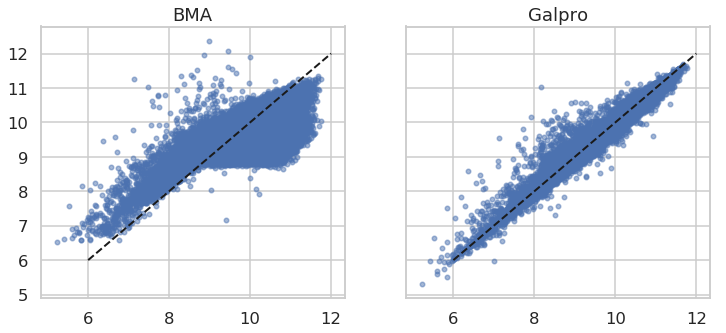

In [26]:
fig, axis = plt.subplots(1, 2, figsize=(12,5), sharex='all',sharey='all')
plot_scatter(data['mass_true'],data['mass_bma'],ax=axis[0],s=20,alpha=0.5,title='BMA',xlims=(6.,12.))
plot_scatter(data['mass_true'],data['mass_ml'],ax=axis[1],s=20,alpha=0.5,title='Galpro',xlims=(6.,12.))